## Random Forest + Cosine Similarities

В данной версии:

1. **Сбалансированные данные** — используется датасет с равным количеством примеров для каждого класса (match, weak_match, related, no_match), что устраняет проблему дисбаланса классов.

2. **Multilingual embeddings + cosine similarity** — текстовые поля кодируются через модель **paraphrase-multilingual-MiniLM-L12-v2** (50+ языков), после чего вычисляются **cosine similarity** между парами эмбеддингов. В качестве признаков используются **только cosine similarity** (без сырых эмбеддингов), так как RandomForest плохо работает с высокоразмерными эмбеддингами.

3. **Cosine similarity для supplier types** — поля `rfq_supplier_types` и `supplier_types` используют разные форматы (UPPER_SNAKE_CASE vs CamelCase) и могут содержать синонимы (MANUFACTURER ≈ Production). Оба поля кодируются через multilingual модель и сравниваются через cosine similarity.

4. **RandomForestClassifier** — нелинейная модель, которая хорошо работает с небольшим количеством информативных скалярных признаков (cosine similarities), строя пороги и их комбинации автоматически.

Классификация: тип совпадения RFQ–Supplier (match, weak_match, related, no_match).

---
## 1. Импорты и настройки


In [13]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer

---
## 2. Загрузка данных

Используется **сбалансированный датасет** (`result_dataset_7k_balanced.csv`) — по 413 примеров на каждый класс (match, weak_match, related, no_match), всего 1652 записи.

In [2]:
data_path = Path("dataset/result_dataset_7k_balanced.csv")
df = pd.read_csv(data_path)

print("Форма датасета:", df.shape)
print("Колонки:", df.columns)
print("\nРаспределение классов:")
print(df["match_type"].value_counts())

Форма датасета: (1652, 15)
Колонки: Index(['rfq_id', 'rfq_title', 'rfq_description', 'quantity',
       'delivery_location', 'rfq_supplier_types', 'supplier_name',
       'supplier_country', 'distribution_area', 'supplier_description',
       'supplier_types', 'products', 'product_categories', 'keywords',
       'match_type'],
      dtype='object')

Распределение классов:
match_type
match         413
no_match      413
related       413
weak_match    413
Name: count, dtype: int64


---
## 3. Предобработка

Очистка полей в формате PostgreSQL-массивов (фигурные скобки), подсчёт пропусков, заполнение пропусков в текстовых полях, формирование текстовых признаков для получения эмбеддингов.

**Важно**: поля `rfq_supplier_types` и `supplier_types` исключены из основных текстовых признаков — они кодируются отдельно через multilingual модель для вычисления cosine similarity между типами поставщика и ожиданиями покупателя, так как например:

покупатель хочет {MANUFACTURER, Wholesaler}, но поставщик предлагает {Production, Wholesaler}, 
понятно, что MANUFACTURER ≈ Production.

In [3]:
def clean_array_field(s: str) -> str:
    if pd.isna(s):
        return ""
   
    s = str(s).strip()
    if s.startswith("{") and s.endswith("}"):
        s = s[1:-1]

    return s.replace(",", ", ")

array_columns = [
    "rfq_supplier_types", "supplier_types", "products", "product_categories", "keywords"
]
for col in array_columns:
    if col in df.columns:
        df[col] = df[col].apply(clean_array_field)

df.head()

,rfq_id,rfq_title,rfq_description,quantity,delivery_location,rfq_supplier_types,supplier_name,supplier_country,distribution_area,supplier_description,supplier_types,products,product_categories,keywords,match_type
0,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,"Berlin, Deutschland","MANUFACTURER, WHOLESALER",NY CORK TEKSTIL ITH IHR SAN VE TIC AS,TR,international,NY-Cork was established in 2017 as Turkey's fi...,Production,"Cork Shoulder Bag with Eco-Friendly Material, ...",Clothing and accessories,"Bags, bag manufacturer, shoulder bags, Cork pr...",match
1,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,"Berlin, Deutschland","MANUFACTURER, WHOLESALER",AMADIACORK DESIGNED BY NATURE,DE,international,Welcome to AmadiaCork\n\nAmadiaCork is a regis...,Production,"Cork fabric - Colorful cork fabrics, Cork Fabr...",Clothing and accessories,"Textilien - Import/Export, Korkstoff, Korklede...",match
2,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,"Berlin, Deutschland","MANUFACTURER, WHOLESALER","FARL CORK UNIPESSOAL, LDA",PT,international,FARL CORK is a company established in late 201...,Production,"Natural yoga block, Fine grain cork block - Yo...",Wood and wood products,"Cortiça - produtos, yoga, cortiça granulada, R...",match
3,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,"Berlin, Deutschland","MANUFACTURER, WHOLESALER",KORKALLEE.DE - ECO-FASHION AUS KORK,DE,europe,KorkAllee.de is Germany's online shop for fash...,Production,,Clothing and accessories,,match
4,000e6a46-ac45-4489-b237-12c15f5fb9a7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",Ich bin auf der Suche nach\n product : ...,10 - 50,"Berlin, Deutschland","MANUFACTURER, WHOLESALER",NY CORK,TR,international,The Nine Years is a premium Istanbul-based bra...,Production,"""CORPORATE GIFTS, HOME AND HOTEL SUPPLIES, W...",Design,"cork bags, cork handbags, cork accessories, wo...",match


In [4]:
nan_counts = df.isna().sum()
has_nans = nan_counts.sum() > 0
if has_nans:
    print("Пропуски по колонкам (до заполнения):")
    for col in df.columns:
        if nan_counts[col] > 0:
            print(f"  {col}: {nan_counts[col]}")
else:
    print("Пропусков нет.")

Пропуски по колонкам (до заполнения):
  distribution_area: 330
  supplier_description: 102


In [ ]:
text_columns = [
    "rfq_title", "rfq_description", "delivery_location", "quantity",
    "rfq_supplier_types", "supplier_name", "supplier_country", "distribution_area",
    "supplier_description", "supplier_types", "products", "product_categories", "keywords"
]
for col in text_columns:
    if col in df.columns:
        df[col] = df[col].fillna("").astype(str)

# для удобства, удаляем distribution_area, так как оно почти всегда пустое;
# а так же на данном этапе сложно и затратно сделать полезное распределение по регионам -
# это будет сделано в следующих версиях.
if "distribution_area" in df.columns:
    df = df.drop(columns=["distribution_area"])

In [11]:
df["rfq_text"] = (
    df["rfq_title"].astype(str) + " "
    + df["rfq_description"].astype(str) + " "
    + df["delivery_location"].astype(str) + " "
    + df["quantity"].astype(str)
)

df["supplier_text"] = (
    df["supplier_name"].astype(str) + " "
    + df["supplier_description"].astype(str) + " "
    + df["supplier_country"].astype(str)
)

df["multilingual_text"] = (
    df["products"].astype(str) + " "
    + df["product_categories"].astype(str) + " "
    + df["keywords"].astype(str)
)

df[["rfq_text", "supplier_text", "multilingual_text"]].head(10)

,rfq_text,supplier_text,multilingual_text
0,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",NY CORK TEKSTIL ITH IHR SAN VE TIC AS NY-Cork ...,"Cork Shoulder Bag with Eco-Friendly Material, ..."
1,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",AMADIACORK DESIGNED BY NATURE Welcome to Amad...,"Cork fabric - Colorful cork fabrics, Cork Fabr..."
2,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...","FARL CORK UNIPESSOAL, LDA FARL CORK is a compa...","Natural yoga block, Fine grain cork block - Yo..."
3,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",KORKALLEE.DE - ECO-FASHION AUS KORK KorkAllee....,Clothing and accessories
4,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",NY CORK The Nine Years is a premium Istanbul-b...,"""CORPORATE GIFTS, HOME AND HOTEL SUPPLIES, W..."
5,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...","EMPREMTA BARCELONA At Empremta Barcelona, we s...",Customizable polyester drawstring backpack 190...
6,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",KORK-STUDIO GROBE BRIGITTE GROBE Everything ma...,"Cork Dartboard, Cork box - Ø 90 x 60 mm, ""Cork..."
7,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",MONARCH CORK & TEXTILE Monarch Textile & Bag '...,"Smyrna Cork Handbag - SKU: MC-A25N, Smyrna Cor..."
8,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...",NY CORK TEKSTIL DERI ITHALAT IHRACAT SAN VE TI...,"""CORK GIFTS PRODUCTS, HOME AND HOTEL DECORATI..."
9,"Korktaschen, Korkrucksäcke, Korkreisetaschen, ...","WHY NOT?, LDA. The journey of Why Not? Bags be...","In-House Collection of Ready-to-Use Models, In..."


---
## 3.1. Cosine Similarity на основе Multilingual Embeddings

Используем модель **paraphrase-multilingual-MiniLM-L12-v2** (384 dim, 50+ языков) для кодирования текстовых полей, после чего вычисляем **cosine similarity** между парами эмбеддингов. Сырые эмбеддинги (1152 dim) **не используются** — RandomForest плохо работает с высокоразмерными dense-векторами.

Признаки (3 cosine similarity):
1. **cos_rfq_supplier** — `rfq_text` <=> `supplier_text`
2. **cos_rfq_multilingual** — `rfq_text` <=> `multilingual_text` (products + categories + keywords)
3. **cos_supplier_types** — `rfq_supplier_types` <=> `supplier_types` (семантическое сравнение: MANUFACTURER ≈ Production)

In [22]:
ml_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

print("Кодируем rfq_text...")
rfq_embeddings = ml_model.encode(
    df["rfq_text"].tolist(), show_progress_bar=True, batch_size=64
)

print("Кодируем supplier_text...")
supplier_embeddings = ml_model.encode(
    df["supplier_text"].tolist(), show_progress_bar=True, batch_size=64
)

print("Кодируем multilingual_text (products + categories + keywords)...")
multilingual_embeddings = ml_model.encode(
    df["multilingual_text"].tolist(), show_progress_bar=True, batch_size=64
)

print("Кодируем rfq_supplier_types и supplier_types...")
rfq_st_embeddings = ml_model.encode(
    df["rfq_supplier_types"].tolist(), show_progress_bar=True, batch_size=64
)
sup_st_embeddings = ml_model.encode(
    df["supplier_types"].tolist(), show_progress_bar=True, batch_size=64
)

df["cos_rfq_supplier"] = [
    sklearn_cosine_similarity(r.reshape(1, -1), s.reshape(1, -1))[0, 0]
    for r, s in zip(rfq_embeddings, supplier_embeddings)
]
df["cos_rfq_multilingual"] = [
    sklearn_cosine_similarity(r.reshape(1, -1), m.reshape(1, -1))[0, 0]
    for r, m in zip(rfq_embeddings, multilingual_embeddings)
]
df["cos_supplier_types"] = [
    sklearn_cosine_similarity(r.reshape(1, -1), s.reshape(1, -1))[0, 0]
    for r, s in zip(rfq_st_embeddings, sup_st_embeddings)
]

feature_cols = ["cos_rfq_supplier", "cos_rfq_multilingual", "cos_supplier_types"]

print(f"\nМодель: paraphrase-multilingual-MiniLM-L12-v2")
print(f"Признаки (только cosine similarity): {len(feature_cols)}")
print(f"\nСтатистика cosine similarity:")
print(df[feature_cols].describe())

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 1523.59it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Кодируем rfq_text...


Batches: 100%|██████████| 26/26 [00:02<00:00, 10.29it/s]


Кодируем supplier_text...


Batches: 100%|██████████| 26/26 [00:02<00:00, 10.01it/s]


Кодируем multilingual_text (products + categories + keywords)...


Batches: 100%|██████████| 26/26 [00:03<00:00,  8.25it/s]


Кодируем rfq_supplier_types и supplier_types...


Batches: 100%|██████████| 26/26 [00:00<00:00, 83.03it/s]



Модель: paraphrase-multilingual-MiniLM-L12-v2
Признаки (только cosine similarity): 3

Статистика cosine similarity:
       cos_rfq_supplier  cos_rfq_multilingual  cos_supplier_types
count       1652.000000           1652.000000         1652.000000
mean           0.303376              0.357756            0.626760
std            0.124805              0.136676            0.253485
min           -0.050240             -0.096924            0.171747
25%            0.218014              0.267850            0.417738
50%            0.299553              0.359911            0.592673
75%            0.388068              0.455972            0.929290
max            0.723701              0.744855            0.990583


---
## 4. Разбиение на обучающую и тестовую выборки (80 / 20)

Используется **GroupShuffleSplit** по ключу `rfq_id`: все строки одного RFQ попадают в одну выборку, чтобы избежать data leakage. Модель (RandomForest) и гиперпараметры были выбраны в предыдущих версиях, поэтому валидационная выборка не нужна.

In [23]:
y = df["match_type"]
groups = df["rfq_id"]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, y, groups))

X_train = df.loc[train_idx, feature_cols]
y_train = y.iloc[train_idx]
X_test = df.loc[test_idx, feature_cols]
y_test = y.iloc[test_idx]

print(f"Размер обучающей выборки (train): {len(X_train)}")
print(f"Размер тестовой выборки (test): {len(X_test)}")
print(f"Количество признаков: {X_train.shape[1]}")

print(f"\nРаспределение классов (train):\n{y_train.value_counts()}")
print(f"\nРаспределение классов (test):\n{y_test.value_counts()}")

Размер обучающей выборки (train): 1254
Размер тестовой выборки (test): 398
Количество признаков: 3

Распределение классов (train):
match_type
weak_match    359
related       324
no_match      303
match         268
Name: count, dtype: int64

Распределение классов (test):
match_type
match         145
no_match      110
related        89
weak_match     54
Name: count, dtype: int64


---
## 5. Модель и обучение

Признаки — **только cosine similarity** (3 dim):
1. `cos_rfq_supplier` — rfq <=> supplier
2. `cos_rfq_multilingual` — rfq <=> multilingual (products + categories + keywords)
3. `cos_supplier_types` — rfq_supplier_types <=> supplier_types

Классификатор: **RandomForestClassifier** с `class_weight='balanced'`.

In [28]:
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

---
## 6. Оценка качества и визуализация

In [29]:
print("Test — classification report:")
print(classification_report(y_test, y_pred, zero_division=0))
print("Test — accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nConfusion matrix (test):")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Test — classification report:
              precision    recall  f1-score   support

       match       0.38      0.13      0.19       145
    no_match       0.51      0.41      0.45       110
     related       0.26      0.37      0.31        89
  weak_match       0.14      0.35      0.20        54

    accuracy                           0.29       398
   macro avg       0.32      0.32      0.29       398
weighted avg       0.36      0.29      0.29       398

Test — accuracy: 0.2915

Confusion matrix (test):
[[19 17 51 58]
 [12 45 28 25]
 [11 15 33 30]
 [ 8 12 15 19]]


In [30]:
importances = clf.feature_importances_

print("Важность признаков:")
for name, imp in sorted(zip(feature_cols, importances), key=lambda x: -x[1]):
    print(f"  {name}: {imp:.4f}")

Важность признаков:
  cos_rfq_multilingual: 0.3725
  cos_rfq_supplier: 0.3708
  cos_supplier_types: 0.2567


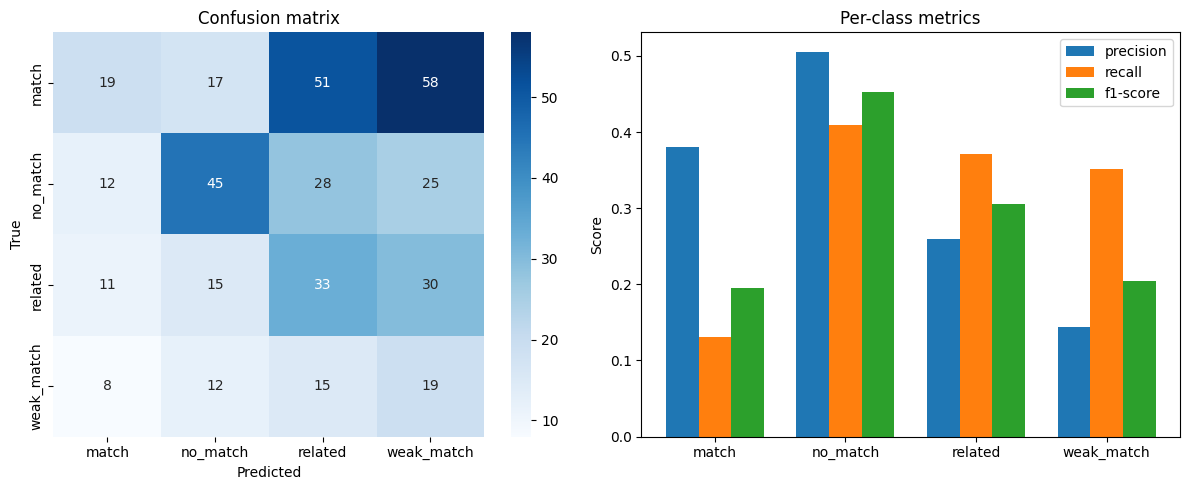

In [31]:
labels = sorted(y.unique())
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(
    cm, xticklabels=labels, yticklabels=labels, annot=True, fmt="d",
    cmap="Blues", ax=axes[0]
)
axes[0].set_title("Confusion matrix")
axes[0].set_ylabel("True")
axes[0].set_xlabel("Predicted")

report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
metrics = ["precision", "recall", "f1-score"]
x = np.arange(len(labels))
width = 0.25
for i, m in enumerate(metrics):
    vals = [report[l].get(m, 0) for l in labels]
    axes[1].bar(x + i * width, vals, width, label=m)
    
axes[1].set_xticks(x + width)
axes[1].set_xticklabels(labels)
axes[1].set_ylabel("Score")
axes[1].set_title("Per-class metrics")
axes[1].legend()

plt.tight_layout()
plt.show()

---
## Выводы

### Что изменилось по сравнению с baseline_naive

| | baseline_naive | classifier_v3 |
|---|---|---|
| **Данные** | Несбалансированные (~68% `no_match`) | Сбалансированные (по 413 на класс) |
| **Текстовые признаки** | TF-IDF | Multilingual embeddings (paraphrase-multilingual-MiniLM-L12-v2) |
| **Взаимодействие rfq↔supplier** | Нет — модель видит TF-IDF отдельно для rfq и supplier | Да — cosine similarity между эмбеддингами |
| **Supplier types** | Входят в общий TF-IDF | Отдельно кодируются и сравниваются через cosine similarity |
| **Кол-во признаков** | Тысячи (TF-IDF sparse) | 3 (cosine similarity) |
| **Test accuracy** | 0.385 | 0.29 |
| **Test macro-F1** | 0.17 | 0.29 |
| **Предсказанные классы** | Почти только `no_match` | Все 4 класса |

### Что показывают результаты

1. **Accuracy baseline_naive выше (0.385 vs 0.29), но это обманчивая метрика.** В baseline данные несбалансированы, и модель просто предсказывает почти всё как `no_match` — это даёт высокую accuracy, но модель по сути бесполезна.

2. **Macro-F1 — более честная метрика для нашей задачи**, потому что она учитывает качество на каждом классе одинаково. По macro-F1 данная версия заметно лучше baseline_naive (0.17). Это значит, что наша модель реально различает классы, а не просто угадывает самый частый.

3. **Cosine similarity работает.** Три простых числа (насколько похож rfq на supplier, на его продукты, и совпадают ли типы поставщика) дают модели больше полезной информации, чем тысячи TF-IDF признаков.

4. **Multilingual embeddings решают проблему языков.** В данных тексты на разных языках (DE, EN и др.). TF-IDF не может сравнить немецкий текст с английским — для него это полностью разные слова. Multilingual модель понимает, что «Korktaschen» и «cork bags» — это одно и то же, и ставит им высокий cosine similarity.

### Почему RandomForest — не лучший выбор для этой задачи

Хотя результаты лучше baseline по macro-F1, accuracy 0.29 на 4-классовой задаче — это всё ещё близко к случайному угадыванию (0.25). Похоже проблема не в данных и не в признаках, а в самом RandomForest.

Что можно еще попробовать:

**Gradient Boosting** был бы лучшим выбором среди tree-based моделей: бустинг последовательно исправляет ошибки предыдущих деревьев и лучше находит сложные паттерны даже при малом числе признаков.

**Нейронные сети / fine-tuning трансформеров** — самый мощный вариант: модель может обучиться напрямую на эмбеддингах (а не на cosine similarity), находя нелинейные комбинации в 384-мерном пространстве, которые RF принципиально не может использовать.